# First we check how we can query or extract information with BERT

## Preprocessing same after webscraping and word2vec approach

In [ ]:
reviews_df = pd.read_csv('reviews.csv')

# Display the first few rows
reviews_df.head()
reviews_df.drop_duplicates(subset='content', inplace=True)
columns_to_drop = ['reviewId', 'userName', 'userImage', 'replyContent', 'repliedAt']
reviews_df.drop(columns=columns_to_drop, inplace=True)
def clean_tokenize(text):
    text = text.lower()
    text = re.sub(r'[^a-z\s]', '', text)
    words = text.split()
    words = [word for word in words if word not in ENGLISH_STOP_WORDS]
    stemmer = SnowballStemmer(language='english')
    words = [stemmer.stem(word) for word in words]
    return ' '.join(words)

reviews_df['content'].fillna("missing_content", inplace=True)
reviews_df['cleaned_content'] = reviews_df['content'].apply(clean_tokenize)

## It is tempting to compare apples to oranges
Considering a query word which has embedding from  WordPiece and comparing it to Bert embeddings generated for the context, has results that are deceptive in that the words appear similar but the relative context is deprecated and perhaps even lost.

In [ ]:
from transformers import BertTokenizer, BertModel
import torch
from sklearn.metrics.pairwise import cosine_similarity
import heapq

# BERT model & tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')

#  similar words - BERT embeddings
def similar_words_bert(word, tokenizer, model, dataset_words):
    # Tokenizing a given word
    tokens = tokenizer.tokenize(word)
    indexed_tokens = tokenizer.convert_tokens_to_ids(tokens)

    # Convert tokens to tensor
    tokens_tensor = torch.tensor([indexed_tokens])

    with torch.no_grad():
        outputs = model(tokens_tensor)
        word_embedding = torch.mean(outputs[0], dim=1).squeeze()

    top_similar_words = []
    for compare_word in dataset_words:
        # double-check each comparison word is a string
        compare_word = str(compare_word)
        
        # Tokenize comparison word
        compare_tokens = tokenizer.tokenize(compare_word)
        compare_indexed_tokens = tokenizer.convert_tokens_to_ids(compare_tokens)
        compare_tokens_tensor = torch.tensor([compare_indexed_tokens])

        with torch.no_grad():
            compare_outputs = model(compare_tokens_tensor)
            compare_embedding = torch.mean(compare_outputs[0], dim=1).squeeze()

        similarity = cosine_similarity(word_embedding.numpy().reshape(1, -1), compare_embedding.numpy().reshape(1, -1))[0][0]
        
        # sort/track 20 most similar words with heapq structure
        if len(top_similar_words) < 20:
            heapq.heappush(top_similar_words, (similarity, compare_word))
        else:
            heapq.heappushpop(top_similar_words, (similarity, compare_word))
    
    # most similar words in descending order
    top_similar_words = sorted(top_similar_words, reverse=True)
    
    return top_similar_words

# words from 'cleaned_content' column 
words_to_compare = reviews_df['cleaned_content'].astype(str).str.split().explode().unique().tolist()

word = "camera"
similar_words_list = similar_words_bert(word, tokenizer, model, words_to_compare)[:20]

print(f"Top 20 most similar words to '{word}':")
for similarity, similar_word in similar_words_list:
    print(f"'{similar_word}': {similarity}")


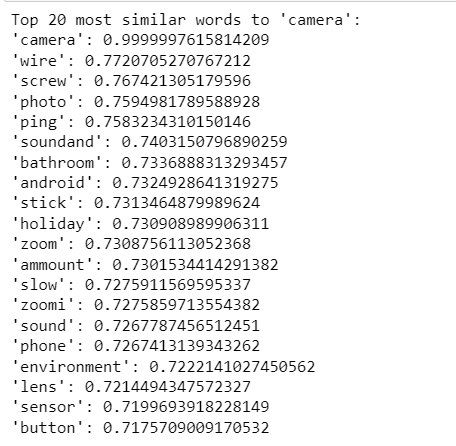

## It is instead more viable to attempt zero-shot inference from pretrained Q&A models (Generate Token from Hugging Face )
### Due to the the way context is loaded into the API, let us consider reviews one at a time. We consider the Snapchat subset

In [ ]:
# Load CSV file as DataFrame
data = pd.read_csv('reviews.csv')

# Filter rows based on the 'appId' for Snapchat
filtered_data = data[data['appId'] == 'com.snapchat.android']

# Saving filtered data in new CSV 
filtered_data.to_csv('filtered_snapchat_data.csv', index=False)


#### Using roberta-base-squad2

In [43]:

import requests

API_URL = "https://api-inference.huggingface.co/models/deepset/roberta-base-squad2"
headers = {"Authorization":  f"Bearer TOKEN"}

def query(payload):
    response = requests.post(API_URL, headers=headers, json=payload)
    return response.json()




# Read the CSV file
dfs = pd.read_csv('filtered_snapchat_data.csv')

# Concatenating all rows from  'context' column
context_string = ' '.join(dfs['content'].astype(str))
quest='Does snapchat have issues for sharing photos with friends?'
#  o/p with the concatenated context (content column)
output = query({
    "inputs": {
        "question": quest,
        "context": context_string
    }
})

print(output)

{'score': 0.44601887464523315, 'start': 225876, 'end': 225907, 'answer': 'Snapchat+ is absolutely useless'}


In [5]:
import pandas as pd
import requests

API_URL = "https://api-inference.huggingface.co/models/deepset/roberta-base-squad2"
headers = {"Authorization":f"Bearer TOKEN"}

def query(payload):
    response = requests.post(API_URL, headers=headers, json=payload)
    return response.json()




# Read CSV
#dfs = pd.read_csv('C:/Users/calmeida/Downloads/filtered_snapchat_data.csv')

# Concatenating all rows from  'context' column
#context_string = ' '.join(dfs['content'].astype(str))
quest='camera quality'
# Generating o/p with the concatenated context (content column)
output = query({
    "inputs": {
        "question": quest,
        "context": context_string
    }
})

print(output)

{'score': 0.7650327682495117, 'start': 78140, 'end': 78146, 'answer': 'blurry'}


#### Using distilbert-base-cased-distilled-squad

In [52]:


API_URL = "https://api-inference.huggingface.co/models/distilbert-base-cased-distilled-squad"
headers = {"Authorization": f"Bearer TOKEN"}

def query(payload):
    response = requests.post(API_URL, headers=headers, json=payload)
    return response.json()





quest='Does snapchat have issues for sharing photos with friends?'
# Generating o/p with the concatenated context
output = query({
    "inputs": {
        "question": quest,
        "context": context_string
    }
})

print(output)

{'score': 0.4245036542415619, 'start': 109352, 'end': 109366, 'answer': 'privacy issues'}


In [3]:
import pandas as pd
import requests

API_URL = "https://api-inference.huggingface.co/models/distilbert-base-cased-distilled-squad"
headers = {"Authorization": f"Bearer TOKEN"}

def query(payload):
    response = requests.post(API_URL, headers=headers, json=payload)
    return response.json()





quest='camera quality'
# Generating o/p with the concatenated context 
output = query({
    "inputs": {
        "question": quest,
        "context": context_strings
    }
})

print(output)

{'score': 0.2302497923374176, 'start': 49075, 'end': 49109, 'answer': 'Camera is rotated 90° and squished'}


## We could also infer a summary and make it available to a user. for ex. Snapchat Review summary- facebook/bart-large-cnn

In [58]:


API_URL = "https://api-inference.huggingface.co/models/facebook/bart-large-cnn"
headers = {"Authorization": f"Bearer TOKEN"}




def query(payload):
    response = requests.post(API_URL, headers=headers, json=payload)
    return response.json()

output = query({
    "inputs": context_string,
})

In [59]:
print(output)

[{'summary_text': " Snapchat was a great app. But after so many updates it only seems to get worse. Is the AI feature and getting notifications when someone is typing really that necessary? It crashes every single time. Video calling with friends has become really glitchy and the audio doesn't work. The advertisement of Snapchat+ is seriously invasive and annoying."}]


## We have sentiment annotated with star rating. If user enters new review, can we auto-rate it? Lets check if pretrained models can infer sentiment correctly . We check the metrics

### bert-base-multilingual-uncased-sentiment model

In [ ]:
import pandas as pd
import requests
from sklearn.metrics import precision_score, recall_score

# Load the CSV file
data = pd.read_csv('filtered_snapchat_data.csv') 

# Random sampling of 50 reviews from our dataset
sampled_reviews = data.sample(n=50, random_state=42) 

# API 

API_URL = "https://api-inference.huggingface.co/models/nlptown/bert-base-multilingual-uncased-sentiment"
headers = {"Authorization": "f Bearer TOKEN"} 

def query(payload):
    response = requests.post(API_URL, headers=headers, json=payload)
    return response.json()

predicted_ratings = []
for idx, review_text in enumerate(sampled_reviews['content']):
    output = query({"inputs": review_text})
    
    if isinstance(output, list) and len(output) > 0:
        # first list of dictionaries
        predictions = output[0]
        # predictions sorted in descending order of the score obtained
        sorted_predictions = sorted(predictions, key=lambda x: x['score'], reverse=True)
        # Pick label for star rating corresponding to highest score
        if len(sorted_predictions) > 0:
            predicted_rating = sorted_predictions[0]['label']
            predicted_ratings.append(predicted_rating)
            
            # actual score of the review
            actual_score = sampled_reviews.iloc[idx]['score']
            
            # predicted rating to numerical value
            label_to_value = {
                "5 stars": 5,
                "4 stars": 4,
                "3 stars": 3,
                "2 stars": 2,
                "1 star": 1
            }
            predicted_numeric = label_to_value.get(predicted_rating, 0)
            
            # Printing each review detail fo reference
            print(f"Review {idx + 1}:")
            print(f"Text: {review_text}")
            print(f"Actual Score: {actual_score}")
            print(f"Predicted Numeric Score: {predicted_numeric}")
            print("-------------")
            
        else:
            print(f"No predictions available for Review {idx + 1}.")
    else:
        print(f"Unexpected/empty response for Review {idx + 1}.")

# predicted ratings are then converted to numerical values
predicted_ratings_numeric = [label_to_value.get(prediction, 0) for prediction in predicted_ratings]

# Actual ratings 
actual_ratings = sampled_reviews['score'].tolist()

# Calculate Precision and Recall
precision = precision_score(actual_ratings, predicted_ratings_numeric, average='weighted')
recall = recall_score(actual_ratings, predicted_ratings_numeric, average='weighted')

print(f"Precision: {precision}")
print(f"Recall: {recall}")


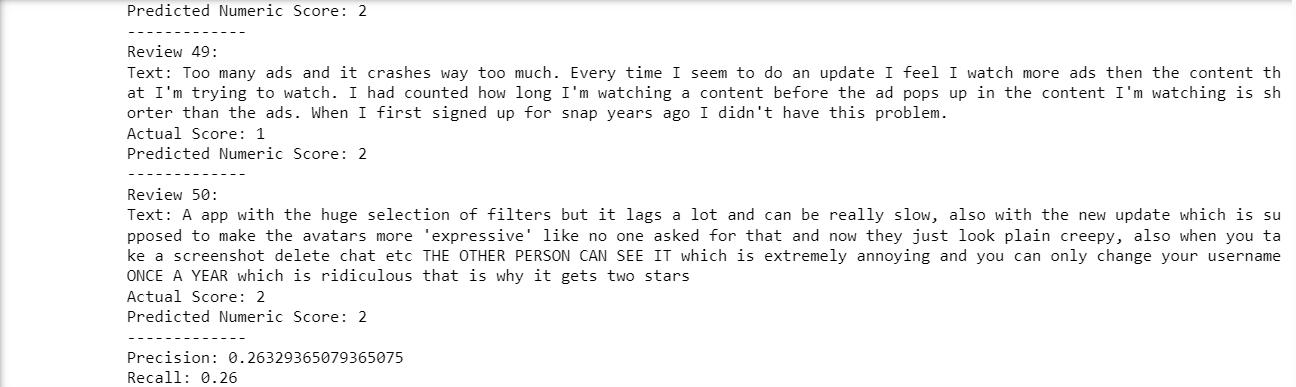

### Poor Metrics . We now try another version of the same model that is fine-tuned on Amazon product reviews: LiYuan/amazon-review-sentiment-analysis


In [ ]:
# Same block from above
sampled_reviews = data.sample(n=50, random_state=42)  


API_URL = "https://api-inference.huggingface.co/models/LiYuan/amazon-review-sentiment-analysis"
headers = {"Authorization": "f Bearer TOKEN"} 

def query(payload):
    response = requests.post(API_URL, headers=headers, json=payload)
    return response.json()

predicted_ratings = []
for idx, review_text in enumerate(sampled_reviews['content']):
    output = query({"inputs": review_text})
    
    if isinstance(output, list) and len(output) > 0:

        predictions = output[0]

        sorted_predictions = sorted(predictions, key=lambda x: x['score'], reverse=True)

        if len(sorted_predictions) > 0:
            predicted_rating = sorted_predictions[0]['label']
            predicted_ratings.append(predicted_rating)
            

            actual_score = sampled_reviews.iloc[idx]['score']
            

            label_to_value = {
                "5 stars": 5,
                "4 stars": 4,
                "3 stars": 3,
                "2 stars": 2,
                "1 star": 1
            }
            predicted_numeric = label_to_value.get(predicted_rating, 0)
            

            print(f"Review {idx + 1}:")
            print(f"Text: {review_text}")
            print(f"Actual Score: {actual_score}")
            print(f"Predicted Numeric Score: {predicted_numeric}")
            print("-------------")
            
        else:
            print(f"No predictions available for Review {idx + 1}.")
    else:
        print(f"Unexpected or empty response received for Review {idx + 1}.")


predicted_ratings_numeric = [label_to_value.get(prediction, 0) for prediction in predicted_ratings]


actual_ratings = sampled_reviews['score'].tolist()


precision = precision_score(actual_ratings, predicted_ratings_numeric, average='weighted')
recall = recall_score(actual_ratings, predicted_ratings_numeric, average='weighted')

print(f"Precision: {precision}")
print(f"Recall: {recall}")

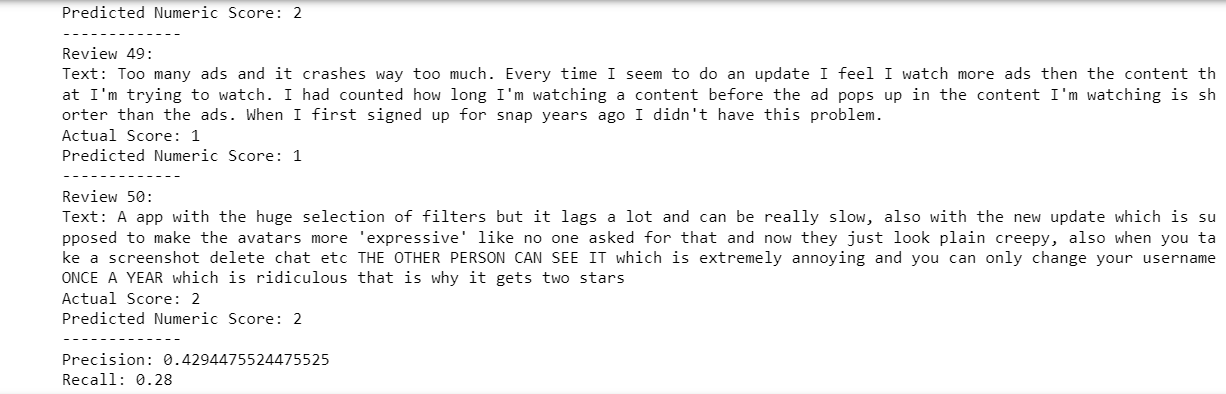

## Precision slightly improves. We may try a fine-tune to see if any further improvment possible w.r.t. metrics

## Further Fine-tuning of of Li Yuan Model on Snapchat review Subset

In [ ]:
import transformers

#print(transformers.__version__)

# Model ( text classification) and Batch Size  

In [ ]:
model_checkpointLY = "LiYuan/amazon-review-sentiment-analysis"
#model_checkpoint = "distilbert-base-uncased"
#model_checkpoint = "bert-base-cased"
batch_size = 16

## dataset metrics load

In [ ]:
from datasets import load_dataset, load_metric, list_metrics

In [ ]:
actual_taskLY = "mnli"
metric = load_metric('glue', actual_task)

## Load dataset

In [ ]:
import datasets
import random
import pandas as pd
import numpy as np


dfLY = pd.read_csv('filtered_english_snapchat_data.csv')


#product = pd.concat(li, axis=0, ignore_index=True)
appLY=dfLY

In [ ]:
appLY

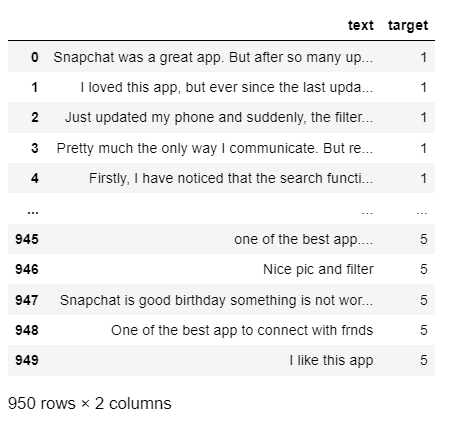

In [ ]:
appLY = appLY.rename(columns={ 'target': 'label'})
alledLY = appLY

In [ ]:
alledLY

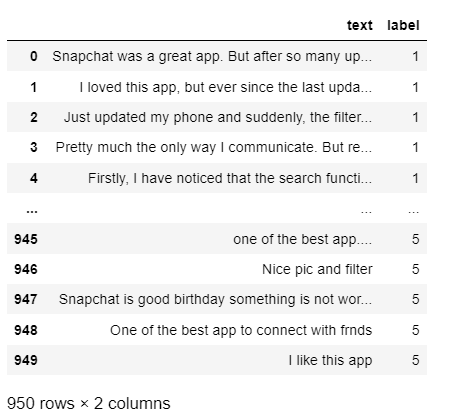

## Split for training, validation, test ( downsample for training)  

In [ ]:
from sklearn.model_selection import train_test_split

frac_train = 0.9
frac_test = 0.8

train_allLY, testLY = train_test_split(alledLY, train_size=frac_train, shuffle=True)
trainLY, devLY = train_test_split(train_allLY, train_size=frac_test, shuffle=True)


In [ ]:
devLY

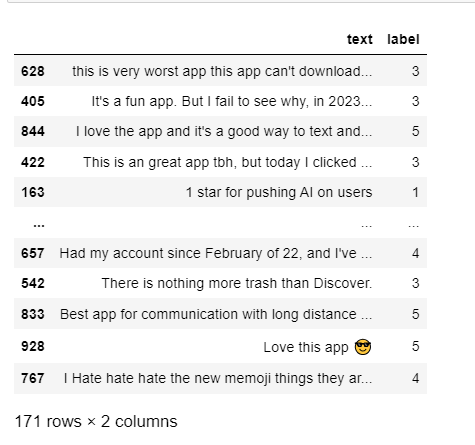

In [ ]:
trainLY = trainLY.dropna()
devLY = devLY.dropna()
testLY = testLY.dropna()

trainLY.reset_index(drop=True, inplace=True)
devLY.reset_index(drop=True, inplace=True)
testLY.reset_index(drop=True, inplace=True)

trainLY = trainLY.astype({'label': int})
devLY = devLY.astype({'label': int})
testLY = testLY.astype({'label': int})

trainLY['label'] = trainLY['label'] - 1
devLY['label'] = devLY['label'] - 1
testLY['label'] = testLY['label'] - 1


In [ ]:
# Save each data section to csv
trainLY.to_csv("C:/Users/calmeida/Downloads/trainLY.csv", index=False)
devLY.to_csv("C:/Users/calmeida/Downloads/devLY.csv", index=False)
testLY.to_csv("C:/Users/calmeida/Downloads/testLY.csv", index=False)

In [ ]:
trainLY.shape
devLY.shape
testLY.shape

## load_dataset the train, validation, test from files

In [ ]:
datasetLY = load_dataset("csv", data_files={'train': 'C:/Users/calmeida/Downloads/trainLY.csv', 'validation': 'C:/Users/calmeida/Downloads/devLY.csv', 'test': 'C:/Users/calmeida/Downloads/testLY.csv'})

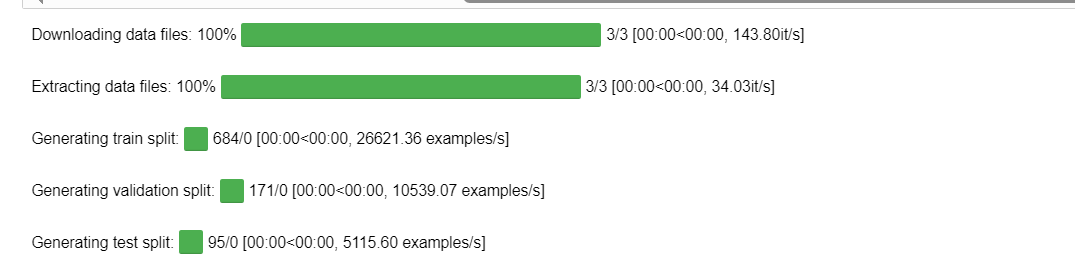 

## Check actual entry within the split

In [ ]:
datasetLY["train"][20]

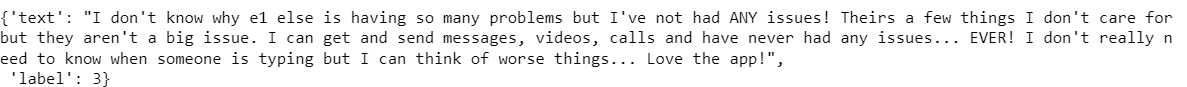

In [ ]:
pip install -U tokenizers

## Preprocessing 

In [ ]:
#`AutoTokenizer.from_pretrained` allows auto-selection of a tokenizer corresponding to the model architecture and also downloads vocab used  we want to use.
from transformers import AutoTokenizer

print(model_checkpointLY)
tokenizer = AutoTokenizer.from_pretrained(model_checkpointLY, use_fast=True)

###  function to preprocess : `tokenizer`-  truncation and padding 

In [ ]:
def preprocess_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True)

### applying this function on all splits of the dataset

In [ ]:
encoded_datasetLY = datasetLY.map(preprocess_function, batched=True)

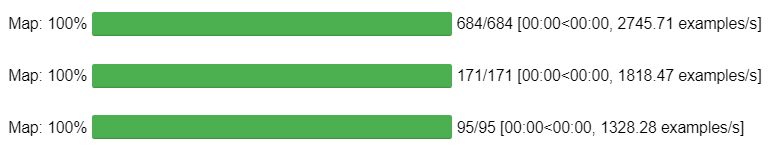

## Fine-tuning details

In [ ]:
#Since we are focussed on sentence classification, we use the `AutoModelForSequenceClassification` class.We specify 5 labels for 5 levels/stars of rating 
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer

print(model_checkpointLY)
num_labels = 5
model = AutoModelForSequenceClassification.from_pretrained(model_checkpointLY, num_labels=num_labels)

In [ ]:
metric_name = "accuracy"
print(metric_name)
model_nameLY = model_checkpointLY.split("/")[-1]
print(model_nameLY)



argsLY = TrainingArguments(
    f"{model_nameLY}-finetuned-{actual_task}",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=5,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model=metric_name,
    push_to_hub=True,
     
)

## `Trainer`

In [ ]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)

In [ ]:
trainerLY = Trainer(
    model,
    argsLY,
    train_dataset=encoded_dataset["train"],
    eval_dataset=encoded_dataset["validation"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

## actual training:

In [ ]:
trainerLY.train()

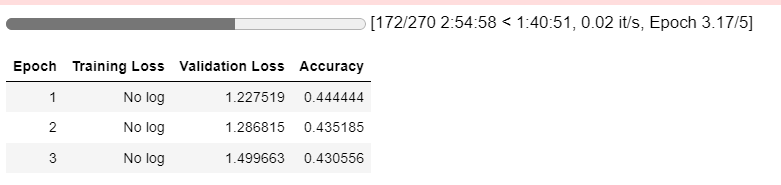

## Training as above was interrupted after 3 epochs due to clear decrease in accuracy. This was on the Snapchat subset. Sometimes a small dataset may not allow for accurate training and overfitting. To overcome this, let us try with All App reviews (We also further filter the scrape to ensure English-only content as during the scrape the request to scrape only EN appears ignored in some cases)

In [ ]:
from langdetect import detect

# Function to detect language of text
def detect_language(text):
    try:
        return detect(text)
    except:
        return 'unknown'

#  CSV file into a DataFrame
data = pd.read_csv('reviews.csv')

#  rows based on the 'appId' column
filtered_data = data[data['appId'] == 'com.snapchat.android']

# language for each row in the 'text' column
filtered_data['language'] = filtered_data['content'].apply(detect_language)

# Remove non-English rows based on the detected language
english_data = filtered_data[filtered_data['language'] == 'en']

# Further filter to keep only 'content' and 'score' columns
english_data_filtered = english_data[['content', 'score']]

# Rename cols 'content' to 'text' and 'score' to 'target'
english_data_filtered = english_data_filtered.rename(columns={'content': 'text', 'score': 'target'})

# Save the filtered English data to new CSV 
english_data_filtered.to_csv('filtered_english_snapchat_data.csv', index=False)

In [ ]:
#new file loaded filtered only for English with All Apps
dfLY = pd.read_csv('english_all_data.csv')

In [ ]:
#remaining code repeats

## training with All App Reviews instead of one App

In [ ]:
trainerLY.train()

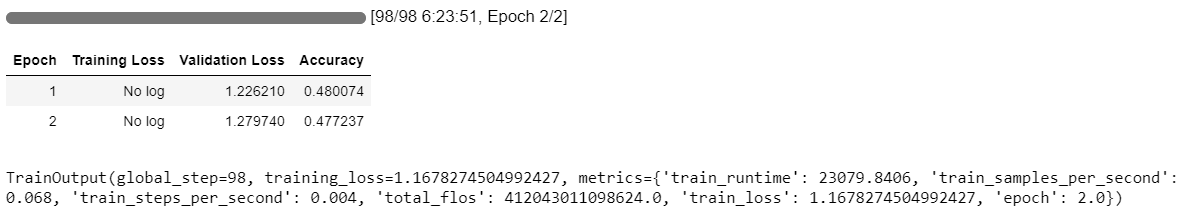

## Barely Any Change in Training accuracy. This dataset may be not suitable for this type of model or may need specific adjustments for the training, test , validation split which may be explored in the future